## 03. Compiling all the plots from literature that show AGN excess as a function of projected separations

The notebook is divided into the following sections:
1. Loading data and defining input parameters
2. Creating the plot

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 15th April 2021

In [1]:
import numpy as np

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# system imports
import os
import sys
import importlib as ib

import scipy.odr as odr

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import plotting_aim03 as pt
import plotting_cswl05 as pt_sim
import Modelling_AGN_fractions_from_literature as mafl
import Comparison_simulation_with_literature_data as cswl
import Agn_incidence_from_Major_Mergers as aimm
import Exploring_DM_Halos as edh

Data directory

In [4]:
lit_dir = 'Data/Literature_plots/'

Optical 

In [5]:
Ellison_11 = np.loadtxt(lit_dir+'E11.txt', skiprows=1)

# Decomposing all the columns from the digitized Ellison et al. file
r_p_E11, f_agn_E11 = mafl.getXY(Ellison_11)

f_agn_err_E11 = [Ellison_11[i][2:4] for i in range(len(Ellison_11))]
r_p_err_E11 = [Ellison_11[i][4:] for i in range(len(Ellison_11))]

Another optical study

In [6]:
Liu_12 = np.genfromtxt(lit_dir+'L12.csv', delimiter=',', skip_header=6)

r_p_L12 = [np.vstack(Liu_12)[i][0] for i in range(len(Liu_12))]
f_agn_L12 = [np.vstack(Liu_12)[i][1] for i in range(len(Liu_12))]
Liu_12_err = np.loadtxt(lit_dir+'L12_yerr.txt', skiprows=1)

Mid-infrared

AGNs were selected using the mid-infrared threshold of $W_1-W_2>0.5$

In [7]:
Satyapal_14 = np.genfromtxt(lit_dir+'S14.csv', delimiter=',', skip_header=6)
Satyapal_14_err = np.loadtxt(lit_dir+'S14_errs.txt', skiprows=1)

# extract info
Satyapal_14 = [Satyapal_14[i][0:2] for i in range(len(Satyapal_14))]
r_p_err_S14, f_agn_err_S14 = mafl.getErrArrays(Satyapal_14_err)

X-rays

In [8]:
Silverman_11 = np.genfromtxt(lit_dir+'Sil11_main.csv', delimiter=',', skip_header=6)
Silverman_11_err = np.loadtxt(lit_dir+'Sil11err.txt', skiprows=1)

# extract info
Silverman_11 = [Silverman_11[i][0:2] for i in range(len(Silverman_11))]
r_p_err_Sil11, f_agn_err_Sil11 = mafl.getErrArrays(Silverman_11_err)

Plotting the AGN fractions from all these different studies

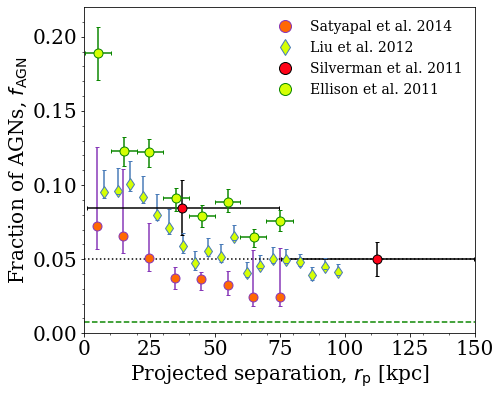

In [9]:
ib.reload(pt)
ax_data, out_data = pt.plotAllLiteraturePlots(Satyapal_14, r_p_err_S14, f_agn_err_S14, r_p_L12, f_agn_L12, Liu_12_err, Silverman_11, r_p_err_Sil11, f_agn_err_Sil11, r_p_E11, f_agn_E11, r_p_err_E11, f_agn_err_E11)
plt.savefig('figures/close_p_all.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Concatenate all the projected separations and fraction of AGNs for fitting purposes

In [10]:
X = np.concatenate([out_data[0][0], out_data[1][0], out_data[2][0], out_data[3][0]], axis=0)
Y = np.concatenate([out_data[0][1], out_data[1][1], out_data[2][1], out_data[3][1]], axis=0)

Concetenate all the errors on each data point for fitting purposes

In [11]:
xerr_all, yerr_all = np.array([]), np.array([])
for i in range(len(out_data)):
    xerr, yerr = out_data[i][2][1]+out_data[i][2][0], out_data[i][3][1]+out_data[i][3][0]
    xerr_all  = np.append(xerr_all, [np.abs(xerr)], axis=None)
    yerr_all = np.append(yerr_all, [np.abs(yerr)], axis=None)

Fitting the data

In [12]:
ib.reload(mafl)
output = mafl.performODR(X, Y, xerr_all, yerr_all)

imported_files/Modelling_AGN_fractions_from_literature.py:51: RuntimeWarning: invalid value encountered in power
  return  -beta[0]/np.power(x, beta[1])


Get confidence levels

In [13]:
pars = output.beta
fit_err = output.sd_beta
output.pprint()

nstd = 1
pars_up, pars_down = pars + nstd*fit_err, pars - nstd*fit_err

Beta: [-0.25525834  0.38327856]
Beta Std Error: [0.05149061 0.05188895]
Beta Covariance: [[ 0.00270984 -0.00267899]
 [-0.00267899  0.00275192]]
Residual Variance: 0.978392723476345
Inverse Condition #: 0.017832974110528085
Reason(s) for Halting:
  Sum of squares convergence


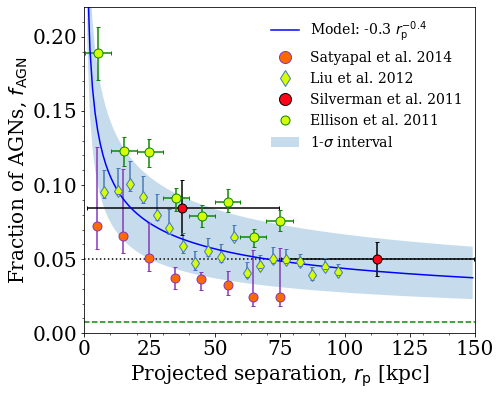

In [14]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

x_new = np.arange(0.1, 150)
ax.plot(x_new, mafl.powerLaw(pars, x_new), 'b', label = r'Model: %.1f $r_{\rm p}^{-%.1f}$'%(pars[0], pars[1]))

_, _ = pt.plotAllLiteraturePlots(Satyapal_14, r_p_err_S14, f_agn_err_S14, r_p_L12, f_agn_L12, Liu_12_err, Silverman_11, r_p_err_Sil11, f_agn_err_Sil11, r_p_E11, f_agn_E11, r_p_err_E11, f_agn_err_E11, ax=ax)

ax.fill_between(x_new, mafl.powerLaw(pars_up, x_new), mafl.powerLaw(pars_down, x_new), alpha=0.25, label=r'1-$\sigma$ interval')

# sets legend properties
l = ax.legend(loc='best',  fontsize=14, frameon=False)
for legend_handle in l.legendHandles[:-2]:
    legend_handle._legmarker.set_markersize(12)
    
plt.savefig('figures/close_p_fitted.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

### Adding the results from simulations

In [18]:
# look back into redshifts until...
redshift_limit = 2

# pixel number from the simulation file
pixel_no = '000000'

_, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['halo']))

# halos
_, _, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)

print("Halos: %d"%(len(hd_halo[conditions_halo]) ))
hd_z_halo = hd_halo[conditions_halo]

# time since merger array [Gyr]
dt_m_arr = [0.5, 1, 2, 3, 4]

n_p_mm_t_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'mm and dv')
n_p_t_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'all')
f_p_selection_c = np.load('Data/pairs_z%.1f/Major_dv_pairs/f_p_wrt_mz_control.npy'%redshift_limit, allow_pickle=True)

Halos: 4506611


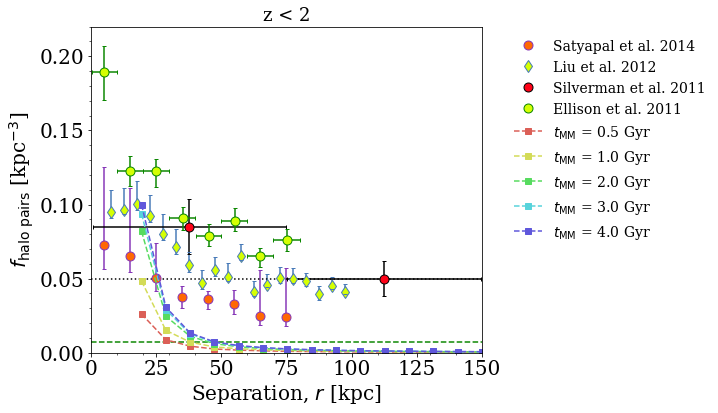

In [26]:
ib.reload(pt_sim)
ib.reload(pt)

fig, ax = plt.subplots(1,1,figsize=(7,6))
errorbars = [False, False, False, False, False]
pal = sns.color_palette("hls", len(dt_m_arr)+1).as_hex()

# get shell volume and projected radius bins [Mpc]
r_p, shell_volume = aimm.shellVolume()

_, _ = pt.plotAllLiteraturePlots(Satyapal_14, r_p_err_S14, f_agn_err_S14, r_p_L12, f_agn_L12, Liu_12_err, Silverman_11, r_p_err_Sil11, f_agn_err_Sil11, r_p_E11, f_agn_E11, r_p_err_E11, f_agn_err_E11, ax=ax, ymax=1.4)
 
for t_idx in range(len(dt_m_arr)):   
    # get absolute fraction by dividing n_p(with cuts, Tmm = t)/n_p(no cuts, Tmm = t)
    _ = pt_sim.plotFpairs(ax, r_p, f_p_selection_c[t_idx], n_p_mm_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar=False)

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [kpc$^{-3}$]', 'z < %d'%redshift_limit, 'default', [0, 0.22], legend=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize=14, frameon=False)